# Precipitation-driven downdrafts in artificial soundings

In [241]:
import sys
import shelve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir

from scipy.interpolate import interp1d
from scipy.signal import argrelmin
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import simpson, solve_ivp
from scipy.stats import norm

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import metpy.constants as const

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)

sys.path.append('../convection_scheme')
from coupler import CoupledThermalGenerator

In [364]:
# fixed parameters
thickness = 2*units.km
t_pert = 1*units.delta_degC
l_crit = 2e-3*units.dimensionless
drag_up, drag_down = 0/units.km, 0/units.km
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.02)*(1/units.km)
epsilon_up = [0.1, 0.3, 0.5]*(1/units.km)
dnu_db = 0*units.second**2/units.meter**2

## Helper functions

In [365]:
def downdraft_init_levels(generator, thickness):
    """Get initiation and precipitation top levels for downdrafts."""
    i_init_down_min = np.min(np.argwhere(generator.height <= 4000*units.meter))
    i_init_down_max = np.max(np.argwhere(generator.height >= 500*units.meter))
    i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
    z_init_down = generator.height[i_init_down_min:i_init_down_max+1:2]
    i_precip_top = np.argmin(np.abs(
        np.atleast_2d(generator.height)
        - np.atleast_2d(z_init_down + thickness).T
    ), axis=1)
    return i_init_down, z_init_down, i_precip_top

In [366]:
def run_updraft(generator, t_pert, l_crit, epsilon_up, drag_up):
    """Run the updraft calculation."""
    i_init_up = generator.pressure.size - 1
    q_pert = (
        saturation_specific_humidity(
            generator.pressure[i_init_up], generator.temperature[i_init_up])
         - generator.specific_humidity[i_init_up]
    )/1.5
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon_up, dnu_db, drag_up, l_crit, basic=True)
    return updraft

In [384]:
def get_total_precip(updraft, i_init_down, i_precip_top):
    """Calculate total precipitation."""
    total_precip = np.zeros(len(i_init_down))*units('')
    for i in range(len(i_init_down)):
        total_precip[i] = np.nansum((
            updraft.precipitation*updraft.m_remaining
        )[i_precip_top[i] : i_init_down[i] + 1])
    return total_precip

In [368]:
def run_downdrafts(generator, i_init_down, total_precip, drag_down):
    """Run the downdraft calculations."""
    downdrafts = np.zeros((len(i_init_down), epsilon_down.size),
                          dtype='object')
    n_calc = epsilon_down.size*len(i_init_down)
    n_done = 0
    for i in range(len(i_init_down)):
        for j in range(epsilon_down.size):
            n_done += 1
            sys.stdout.write(f'\r        Calculation {n_done} of {n_calc}    ')
            downdrafts[i,j] = generator.precipitation_downdraft(
                i_init_down[i], total_precip[i], w_initial,
                epsilon_down[j], dnu_db, drag_down, basic=True)
    sys.stdout.write('\n')
    return downdrafts

In [369]:
def get_downdraft_data(generator, downdrafts):
    """Find max downdraft velocity and min height."""
    max_velocity = np.zeros(downdrafts.shape)*units('m/s')
    max_velocity_height = np.zeros(downdrafts.shape)*units.meter
    min_height = np.zeros(downdrafts.shape)*units.meter

    for i in range(downdrafts.shape[0]):
        for j in range(downdrafts.shape[1]):
            max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
            max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
            max_velocity_height[i,j] = generator.height[max_velocity_i]
            min_height_i = np.max(
                np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
            min_height[i,j] = generator.height[min_height_i]
            
    return max_velocity, max_velocity_height, min_height

In [370]:
def multiple_downdraft_runs(
        generator, name, thickness, t_pert, l_crit, drag_up, drag_down):
    """Do a downdraft run for each updraft entrainment rate."""
    print('Starting run ' + name + ' ...')
    
    (i_init_down,
     z_init_down,
     i_precip_top) = downdraft_init_levels(generator, thickness)
    theta_e = equivalent_potential_temperature(
        generator.pressure, generator.temperature, generator.specific_humidity)
    z_min_theta_e = generator.height[np.argmin(theta_e)]
    
    w_max_all = []
    z_w_max_all = []
    z_min_all = []
    z_max_evap_all = []
    
    for eps in epsilon_up:
        print('    epsilon_up = {:.2f} /km ...'.format(eps.m))
        updraft = run_updraft(generator, t_pert, l_crit, eps, drag_up)
        total_precip = get_total_precip(updraft, i_init_down, i_precip_top)
        downdrafts = run_downdrafts(
            generator, i_init_down, total_precip, drag_down)
        w_max, z_w_max, z_min = get_downdraft_data(generator, downdrafts)
        z_max_evap = z_init_down[np.argmax(total_precip, axis=0)]
        
        w_max_all.append(w_max)
        z_w_max_all.append(z_w_max)
        z_min_all.append(z_min)
        z_max_evap_all.append(z_max_evap)
        
    with shelve.open('generalising_coupling_data/' + name) as db:
        db['z_init_down'] = z_init_down
        db['z_min_theta_e'] = z_min_theta_e
        db['z_max_evap'] = z_max_evap_all
        db['w_max'] = w_max_all
        db['z_w_max'] = z_w_max_all
        db['z_min'] = z_min_all

## Artificial sounding

In [3]:
def smooth_sounding(pressure, temperature, specific_humidity):
    theta_e = equivalent_potential_temperature(
        pressure, temperature, specific_humidity)
    theta_e_new = gaussian_filter1d(theta_e, sigma=4)*units.kelvin
    q_new = gaussian_filter1d(specific_humidity, sigma=4)*units.dimensionless
    t_new = np.copy(temperature)
    for _ in range(10):
        value, slope = equivalent_potential_temperature(
            pressure, t_new, q_new, prime=True)
        t_new -= (value - theta_e_new)/slope
    return t_new, q_new

In [413]:
df = WyomingUpperAir.request_data(datetime(2021, 12, 7, 0), '91285')
df = df.dropna()
sounding = df[['pressure', 'height', 'temperature', 'dewpoint']].to_numpy()

pressure_raw = sounding[:,0]
height_raw = sounding[:,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:,2]
dewpoint_raw = sounding[:,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

temperature, specific_humidity = smooth_sounding(
    pressure, temperature, specific_humidity)
dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure, temperature, specific_humidity)

hilo_smoothed = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

/Users/z5310829/opt/miniconda3/envs/notebooks/lib/python3.9/site-packages/metpy/calc/thermo.py:1061: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


In [357]:
i_950 = np.argmin(np.abs(pressure - 950*units.mbar))
t_new = np.zeros(height.size)*units.kelvin
t_new[:i_950+1] = mpcalc.dry_lapse(pressure[:i_950+1], temperature[0])
t_new[i_950+1:] = mpcalc.moist_lapse(pressure[i_950+1:], t_new[i_950])
i_180 = np.argmin(np.abs(pressure - 160*units.mbar))
t_new[i_180:] = t_new[i_180]
t_new[i_950:] -= (
    (1 - np.exp(-(height[i_950:] - height[i_950])/(2*units.km)))
    * (5*units.kelvin)
)
t_new[i_950:] = gaussian_filter1d(t_new[i_950:], sigma=5)*units.kelvin

q_new = saturation_specific_humidity(pressure, t_new)
q_new /= np.linspace(1, 1.5, height.size)
q_new -= norm.pdf((height.m_as(units.km) - 4)/1.5)*(5e-3*units.dimensionless)
q_new[:i_950+1] = saturation_specific_humidity(pressure[i_950], t_new[i_950])
# q_new = np.minimum(q_new, saturation_specific_humidity(pressure, t_new))

td_new = mpcalc.dewpoint_from_specific_humidity(pressure, t_new, q_new)

theta_e_new = equivalent_potential_temperature(pressure, t_new, q_new)

interp = interp1d(pressure, mpcalc.density(pressure, t_new, r_new),
               fill_value='extrapolate')
rho = lambda p: interp(p.m_as(units.mbar))*units('kg/m^3')
z_new = solve_ivp(
    lambda p, z: (-1/(rho(p*units.mbar)*const.g)).m_as(units('m/mbar')),
    t_span=[pressure[0].m, pressure[-1].m], y0=(0,), t_eval=pressure.m,
).y*units.meter
z_new = np.squeeze(z_new)

Text(0.5, 1.03, 'Artificial sounding')

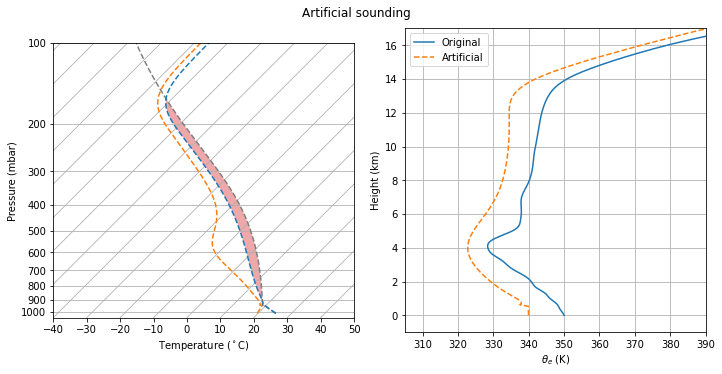

In [411]:
profile = mpcalc.parcel_profile(pressure, temperature[0], dewpoint[0])
cape, cin = mpcalc.cape_cin(pressure, temperature, dewpoint, profile)
theta_e = equivalent_potential_temperature(
    pressure, temperature, specific_humidity)

profile_new = mpcalc.parcel_profile(pressure, t_new[0], td_new[0])
cape_new, cin_new = mpcalc.cape_cin(pressure, t_new, td_new, profile_new)

fig = plt.figure(figsize=(10,5))
skew = SkewT(fig, rotation=45, subplot=(1, 2, 1))
skew.plot(pressure, profile_new, '--', color='0.5')
skew.plot(pressure, t_new, '--', color='tab:blue')
skew.plot(pressure, td_new, '--', color='tab:orange')
skew.shade_cape(pressure, t_new, profile_new)
skew.ax.set(ylabel='Pressure (mbar)', xlabel='Temperature ($^\circ$C)')

ax = fig.add_subplot(122)
ax.plot(theta_e, height.to(units.km), label='Original')
ax.plot(theta_e_new, height.to(units.km), '--', label='Artificial')
ax.legend()
ax.grid()
ax.set_xlim(305, 390)
ax.set_ylim(-1, 17)
ax.set(xlabel='$\\theta_e$ (K)', ylabel='Height (km)')
fig.tight_layout()
fig.suptitle('Artificial sounding', y=1.03)

In [363]:
artificial = CoupledThermalGenerator(
    np.flip(pressure), np.flip(z_new), np.flip(t_new), np.flip(q_new))

## Experiment

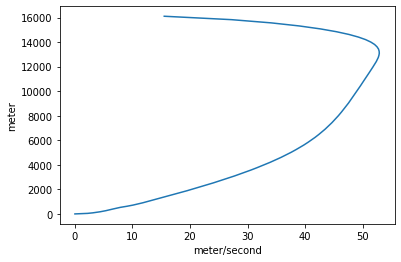

In [382]:
updraft = run_updraft(artificial, t_pert, l_crit, 0.1/units.km, drag_up)
fig, ax = plt.subplots()
ax.plot(updraft.velocity, artificial.height)

In [385]:
%%time
multiple_downdraft_runs(
    artificial, 'artificial_hilo', thickness, t_pert,
    l_crit, drag_up, drag_down)

Starting run artificial_hilo ...
    epsilon_up = 0.10 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.30 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.50 /km ...
        Calculation 924 of 924    
CPU times: user 6min 12s, sys: 2.94 s, total: 6min 15s
Wall time: 6min 17s


In [414]:
df = WyomingUpperAir.request_data(datetime(2021, 12, 1, 0), '48698')
df = df.dropna().drop(range(3))
sounding = df[['pressure', 'height', 'temperature', 'dewpoint']].to_numpy()

pressure_raw = sounding[:,0]
height_raw = sounding[:,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[:,2]
dewpoint_raw = sounding[:,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], -5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

temperature, specific_humidity = smooth_sounding(
    pressure, temperature, specific_humidity)
dewpoint = mpcalc.dewpoint_from_specific_humidity(
    pressure, temperature, specific_humidity)

singapore_smoothed = CoupledThermalGenerator(
    np.flip(pressure), np.flip(height), np.flip(temperature),
    np.flip(specific_humidity))

/Users/z5310829/opt/miniconda3/envs/notebooks/lib/python3.9/site-packages/metpy/calc/thermo.py:1061: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')


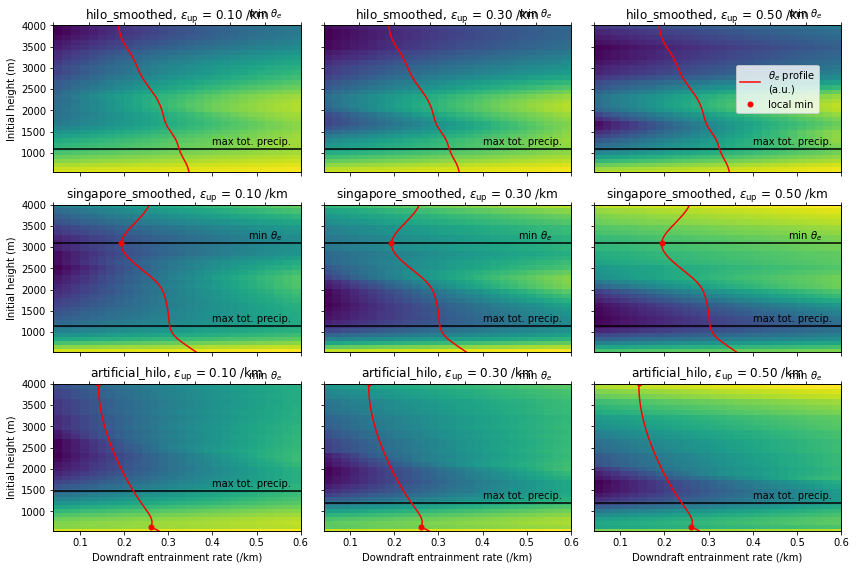

In [419]:
fig, axes = plt.subplots(3, 3, figsize=(12,8))

for i, name in enumerate([
        'hilo_smoothed', 'singapore_smoothed', 'artificial_hilo']):
    db = shelve.open('generalising_coupling_data/' + name)
    sounding = {'hilo_smoothed': hilo_smoothed,
                'singapore_smoothed': singapore_smoothed,
                'artificial_hilo': artificial}[name]
    theta_e = equivalent_potential_temperature(
        sounding.pressure, sounding.temperature, sounding.specific_humidity)
    i_relmin_theta_e = argrelmin(theta_e, order=4)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        ax = axes[i,j].twiny()
        ax.plot(theta_e, sounding.height,
                label='$\\theta_e$ profile\n(a.u.)', color='r')
        ax.plot(theta_e[i_relmin_theta_e], sounding.height[i_relmin_theta_e],
                'r.', markersize=10, label='local min')
        ax.set_xlim(310, 380)
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
        title = (name
                 + r', $\epsilon_\mathrm{{up}}$ = {:.2f} /km'.format(eps.m))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.86, 0.8))
    
for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
fig.tight_layout()